In [218]:
import pandas as pd
import glob
import re
from bs4 import BeautifulSoup
import html
import matplotlib.pyplot as plt
import seaborn as sns

In [219]:
pd.set_option('display.max_columns', None)

### Investigacion

In [220]:
df_inve = pd.read_csv("./data/investigacion/proyectos.csv")
df_inve_ods = pd.read_csv("./data/investigacion/ods.csv")

In [221]:
df_inve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 51 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   IDDECINVPROYECTOOBJODS          879 non-null    int64  
 1   IDDECINVPROYECTO                879 non-null    int64  
 2   IDDECINVOBJODS                  879 non-null    int64  
 3   ULTIMO_CAMBIO                   879 non-null    object 
 4   IDDECINVPROYECTODATOSGENERALES  879 non-null    int64  
 5   IDDECINVPROYECTO.1              879 non-null    int64  
 6   TITULO                          879 non-null    object 
 7   TIPOPROYECTO                    879 non-null    int64  
 8   TIPOINVESTIGACION               879 non-null    int64  
 9   OBJETIVOGENERAL                 879 non-null    object 
 10  MESES                           879 non-null    int64  
 11  FECHAINICIO                     879 non-null    object 
 12  FECHAFIN                        879 

In [222]:
# df_inve.head()

In [223]:
df_inve["ODS_Numero_descripcion"] = pd.Series([pd.NA] * len(df_inve), dtype=object)
for i in range(df_inve.shape[0]):
        df_inve.loc[i, "ODS_Numero_descripcion"] = df_inve_ods["NOMBRE"].iloc[df_inve.loc[i, "IDDECINVOBJODS"]-1]

In [224]:
df_inve[["TITULO", "OBJETIVOGENERAL", "IDDECINVOBJODS", "ODS_Numero_descripcion"]].head()#.loc[0, "OBJETIVOGENERAL"]

,TITULO,OBJETIVOGENERAL,IDDECINVOBJODS,ODS_Numero_descripcion
0,Mapa de la investigación en diseño en Iberoamé...,ANALIZAR LAS LÍNEAS DE INVESTIGACIÓN PRESENTES...,9,"9.- INDUSTRIA, INNOVACIÓN E INFRAESTRUCTURA"
1,Marco de habilidades digitales en Ecuador,VALIDAR UN MARCO DE HABILIDADES DIGITALES PARA...,4,4.- EDUCACIÓN DE CALIDAD
2,Desarrollo de Sistemas Inteligentes de Monitor...,CREAR SISTEMA DE MONITOREO INTELIGENTE UTILIZA...,9,"9.- INDUSTRIA, INNOVACIÓN E INFRAESTRUCTURA"
3,Understanding biodiversity – productivity rela...,TO UNDESTAND THE ROL OF BIODIVERSITY IN HIGLY ...,13,13.- ACCIÓN POR EL CLIMA
4,Understanding biodiversity – productivity rela...,TO UNDESTAND THE ROL OF BIODIVERSITY IN HIGLY ...,15,15.- VIDA DE ECOSISTEMAS TERRESTRES


### Vinculacion

In [225]:
df_vincu = pd.read_csv("./data/vinculacion/proyectos.csv")

In [226]:
df_vincu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   NOMBREPROYECTO  242 non-null    object
 1   ODS             242 non-null    object
 2   ANTECEDENTES    242 non-null    object
 3   CONTEXTO        242 non-null    object
 4   DEFINICION      242 non-null    object
dtypes: object(5)
memory usage: 9.6+ KB


In [227]:
df_vincu.head()

,NOMBREPROYECTO,ODS,ANTECEDENTES,CONTEXTO,DEFINICION
0,Caracterización de playas de la comuna Libert...,14.-Conservar y utilizar sosteniblemente los o...,La Comuna Libertador Bolívar -Atravezado- está...,El uso incremental y desorganizado de las play...,El problema central es la falta de información...
1,Construcción Segura en tiempos de pandemia 2021,11.-Lograr que las ciudades y los asentamiento...,Como se expuso en la conferencia denominada “H...,En un levantamiento cuantitativo y cualitativo...,Falta de conocimiento y concienciación sobre l...
2,Modelo de sostenibilidad con el uso de plataf...,"2.-Poner fin al hambre, lograr la seguridad al...","En el mes de abril del 2023, los profesores de...","El Ecuador tiene 17.3 millones de habitantes, ...",En la unidad educativa Fermín Vera Rojas y Jua...
3,"""Desarrollo de habilidades tecnológicas utiliz...",4.-Garantizar una educación inclusiva y equita...,El estudio socioeconómico del Recinto La Unión...,"El recinto cuenta con una sola escuela fiscal,...",Debido a la falta de conocimientos básicos de ...
4,"“Siembra, cosecha y reutilización del agua par...",6.-Garantizar la disponibilidad y la gestión s...,La estructura política en la que está dividida...,"En la zona Sur de la provincia de Santa Elena,...",Entorno al contexto hidrológico de las zonas d...


In [228]:
df_vincu["ODS"].iloc[1]

'11.-Lograr que las ciudades y los asentamientos humanos sean inclusivos, seguros, resilientes y sostenibles|9.-Construir infraestructuras resilientes, promover la industrialización inclusiva y sostenible y fomentar la innovación'

In [229]:
# ---------------------------------------------------------------------------
# Función 1: expandir_columna_ods (ACTUALIZADA para el nuevo formato)
# ---------------------------------------------------------------------------
def expandir_columna_ods(df_original, nombre_columna_ods='ODS'):
    """
    Expande una columna que contiene múltiples Objetivos de Desarrollo Sostenible (ODS).
    Maneja formatos como:
    - "NUMERO.-TEXTO|NUMERO.-TEXTO"
    - "ODS: NUMERO.-TEXTO|| ODS: NUMERO.-TEXTO"
    - Mezclas de los anteriores.

    Crea:
    1. Una columna '{nombre_columna_ods}_numeros_lista' con una cadena de los números
       de ODS encontrados, ordenados y separados por comas (ej: "9, 11").
    2. Columnas individuales para cada ODS (ej: '{nombre_columna_ods}_9', 
       '{nombre_columna_ods}_11') que contienen el texto descriptivo del ODS
       si está presente en la fila, o pd.NA si no.
    """
    df = df_original.copy()
    col_lista_numeros_nombre = f'{nombre_columna_ods}_numeros_lista'
    df[col_lista_numeros_nombre] = '' # Inicializarla como cadena vacía

    ods_extraidos_por_fila = [] # Lista de diccionarios [{num_str: texto_ods}, ...]
    todos_los_numeros_ods_unicos = set()

    # Patrón regex actualizado:
    # (?:ODS:\s*)? : Grupo opcional sin captura para "ODS: " seguido de espacios.
    # (\d+)         : Grupo 1, captura el número del ODS.
    # \s*\.\s*-\s*  : Coincide con ".-" rodeado de espacios opcionales.
    # (.+)          : Grupo 2, captura el texto descriptivo del ODS.
    patron_ods = re.compile(r"(?:ODS:\s*)?(\d+)\s*\.\s*-\s*(.+)")

    for index, row in df.iterrows():
        valor_celda_ods = row[nombre_columna_ods]
        numeros_en_esta_fila = []
        ods_de_esta_fila = {} 

        if pd.notna(valor_celda_ods) and str(valor_celda_ods).strip():
            # Usar re.split para manejar "||" con espacios opcionales como separador.
            # También maneja el caso de un solo "|" si ese fuera el separador en otras filas.
            # Si solo hay un ODS, split no lo afectará negativamente.
            partes_ods = re.split(r'\s*\|{1,2}\s*', str(valor_celda_ods))
            
            for parte in partes_ods:
                parte_limpia = parte.strip()
                if not parte_limpia: # Saltar si la parte está vacía después del split
                    continue
                
                match = patron_ods.match(parte_limpia)
                if match:
                    numero_str = match.group(1)
                    texto_ods = match.group(2).strip()
                    
                    numeros_en_esta_fila.append(numero_str)
                    ods_de_esta_fila[numero_str] = texto_ods
                    todos_los_numeros_ods_unicos.add(numero_str)
        
        if numeros_en_esta_fila:
            numeros_ordenados_unicos = sorted(list(set(numeros_en_esta_fila)), key=int)
            df.loc[index, col_lista_numeros_nombre] = ", ".join(numeros_ordenados_unicos)
        else:
            # Asegurar que si no hay ODS, la columna de lista de números quede vacía o pd.NA
            df.loc[index, col_lista_numeros_nombre] = pd.NA # O "" si prefieres cadena vacía

        ods_extraidos_por_fila.append(ods_de_esta_fila)

    # Crear las columnas individuales para cada ODS (ej. ODS_9, ODS_11)
    numeros_ods_globales_ordenados = sorted(list(todos_los_numeros_ods_unicos), key=int)

    for num_ods_str in numeros_ods_globales_ordenados:
        nombre_nueva_columna = f'{nombre_columna_ods}_{num_ods_str}'
        df[nombre_nueva_columna] = pd.Series([pd.NA] * len(df), dtype=object) 

    # Llenar las nuevas columnas ODS_X con el texto correspondiente
    # Es importante usar el índice original del DataFrame 'df' para la asignación con .loc
    for i, ods_fila_actual in enumerate(ods_extraidos_por_fila):
        idx = df.index[i] # Obtener el índice original de la fila
        for num_ods_str, texto_ods in ods_fila_actual.items():
            nombre_columna_especifica = f'{nombre_columna_ods}_{num_ods_str}'
            df.loc[idx, nombre_columna_especifica] = texto_ods
            
    return df

In [230]:
# ---------------------------------------------------------------------------
# Función 2: explotar_dataframe_por_ods (CORREGIDA)
# ---------------------------------------------------------------------------
def explotar_dataframe_por_ods(df_con_ods_expandidos, columna_con_lista_numeros, nuevo_nombre_col_ods_individual, prefijo_col_descripcion_ods):
    """
    Transforma un DataFrame repitiendo filas por cada ODS individual
    presente en una columna de lista de números de ODS. También añade la descripción correcta.
    """
    df_explotado = df_con_ods_expandidos.copy()

    # 1. Convertir la cadena de números de ODS en una lista de strings
    def convertir_a_lista(cadena_numeros):
        if pd.isna(cadena_numeros) or not str(cadena_numeros).strip():
            return [] 
        return [num.strip() for num in str(cadena_numeros).split(',')]

    df_explotado[columna_con_lista_numeros] = df_explotado[columna_con_lista_numeros].apply(convertir_a_lista)

    # 2. Usar la función explode de pandas
    # Guardar el índice original si se quiere mantener alguna referencia, aunque aquí lo resetearemos
    df_explotado = df_explotado.explode(columna_con_lista_numeros)

    # 3. Renombrar la columna que ahora contiene el ODS individual
    df_explotado.rename(columns={columna_con_lista_numeros: nuevo_nombre_col_ods_individual}, inplace=True)
    
    # 4. Convertir la nueva columna de ODS a tipo numérico (entero)
    df_explotado[nuevo_nombre_col_ods_individual] = pd.to_numeric(
        df_explotado[nuevo_nombre_col_ods_individual], 
        errors='coerce'
    ).astype('Int64')

    # 5. Limpiar filas donde el ODS individual es NaN (debido a coerce o listas vacías originales)
    df_explotado.dropna(subset=[nuevo_nombre_col_ods_individual], inplace=True)
    
    # 6. Añadir la columna con la descripción del ODS (CORREGIDO)
    col_descripcion_final = f'{nuevo_nombre_col_ods_individual}_descripcion'
    
    def obtener_descripcion_correcta(row):
        ods_num_actual = row[nuevo_nombre_col_ods_individual]
        if pd.notna(ods_num_actual):
            # Construir el nombre de la columna de descripción original (ej. 'ODS_9')
            # Estas columnas (ODS_1, ODS_9, etc.) fueron copiadas por la operación 'explode'
            # y están disponibles en 'row'.
            columna_descripcion_original = f"{prefijo_col_descripcion_ods}_{int(ods_num_actual)}"
            
            # Verificar que la columna de descripción exista en la fila (debería)
            # y que tenga un valor
            if columna_descripcion_original in row.index and pd.notna(row[columna_descripcion_original]):
                return row[columna_descripcion_original]
        return pd.NA # Usar pd.NA para consistencia

    df_explotado[col_descripcion_final] = df_explotado.apply(obtener_descripcion_correcta, axis=1)

    return df_explotado.reset_index(drop=True)

In [231]:
# PASO 1: Aplicar la función de expansión de ODS (de la respuesta anterior)
# El nombre de la columna original de ODS es 'ODS'
df_con_ods_expandidos = expandir_columna_ods(df_vincu, nombre_columna_ods='ODS')

In [232]:
# df_con_ods_expandidos.head()

In [233]:
# PASO 2: Aplicar la nueva función para explotar el DataFrame
# - La columna con la lista de números se llama 'ODS_numeros_lista' (creada por expandir_columna_ods)
# - Queremos que la nueva columna con el ODS individual se llame 'ODS_Numero'
# - El prefijo para las columnas de descripción es 'ODS' (porque las columnas son ODS_1, ODS_9, etc.)
df_final_explotado = explotar_dataframe_por_ods(
    df_con_ods_expandidos,
    columna_con_lista_numeros='ODS_numeros_lista',
    nuevo_nombre_col_ods_individual='ODS_Numero',
    prefijo_col_descripcion_ods='ODS'
)

# Opcional: Si ya no necesitas las columnas ODS_1, ODS_9, ODS_17, etc. y la columna ODS original, puedes eliminarlas.
# Para hacerlo de forma dinámica, necesitarías identificar esas columnas.
# Por ejemplo, todas las columnas que empiezan con "ODS_" y terminan en un número.
columnas_a_eliminar = [col for col in df_final_explotado.columns if re.match(r'^ODS_\d+$', col)]
columnas_a_eliminar.append('ODS') # La columna original
# También la columna 'ODS_numeros_lista' si ya no la quieres en el resultado final
# (aunque ya fue renombrada y explotada, así que no debería estar con ese nombre)

df_limpio = df_final_explotado.drop(columns=columnas_a_eliminar, errors='ignore')

In [234]:
df_vincu.shape, df_con_ods_expandidos.shape, df_limpio.shape

((242, 5), (242, 23), (569, 6))

In [235]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   NOMBREPROYECTO          569 non-null    object
 1   ANTECEDENTES            569 non-null    object
 2   CONTEXTO                569 non-null    object
 3   DEFINICION              569 non-null    object
 4   ODS_Numero              569 non-null    Int64 
 5   ODS_Numero_descripcion  569 non-null    object
dtypes: Int64(1), object(5)
memory usage: 27.4+ KB


In [236]:
# df_final_explotado[['ID_proyecto', 'Otra_Columna', 'ODS_Numero', 'ODS_Numero_descripcion']]
# df_limpio[df_limpio["NOMBREPROYECTO"] == "Viviendas Seguras y Resilientes 2023"]
df_limpio.head()

,NOMBREPROYECTO,ANTECEDENTES,CONTEXTO,DEFINICION,ODS_Numero,ODS_Numero_descripcion
0,Caracterización de playas de la comuna Libert...,La Comuna Libertador Bolívar -Atravezado- está...,El uso incremental y desorganizado de las play...,El problema central es la falta de información...,14,Conservar y utilizar sosteniblemente los océan...
1,Construcción Segura en tiempos de pandemia 2021,Como se expuso en la conferencia denominada “H...,En un levantamiento cuantitativo y cualitativo...,Falta de conocimiento y concienciación sobre l...,9,"Construir infraestructuras resilientes, promov..."
2,Construcción Segura en tiempos de pandemia 2021,Como se expuso en la conferencia denominada “H...,En un levantamiento cuantitativo y cualitativo...,Falta de conocimiento y concienciación sobre l...,11,Lograr que las ciudades y los asentamientos hu...
3,Modelo de sostenibilidad con el uso de plataf...,"En el mes de abril del 2023, los profesores de...","El Ecuador tiene 17.3 millones de habitantes, ...",En la unidad educativa Fermín Vera Rojas y Jua...,2,"Poner fin al hambre, lograr la seguridad alime..."
4,Modelo de sostenibilidad con el uso de plataf...,"En el mes de abril del 2023, los profesores de...","El Ecuador tiene 17.3 millones de habitantes, ...",En la unidad educativa Fermín Vera Rojas y Jua...,3,Garantizar una vida sana y promover el bienest...


### Integradora

In [237]:
step = 1
for file in glob.glob("./data/integradora/*.csv"):
    df = pd.read_csv(file,delimiter=',')
    año = int(file.split("\\")[-1][:4])
    df["año"] = año
    print(año, df.shape)

    if step: 
        step = 0
        big_df = df.copy()
    else:
        big_df = pd.concat([big_df, df], ignore_index=True)

2020 (843, 19)
2020 (839, 19)
2021 (792, 19)
2021 (715, 19)
2022 (828, 19)
2022 (710, 19)
2023 (767, 19)
2023 (726, 19)
2024 (699, 19)
2024 (685, 19)


In [238]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7604 entries, 0 to 7603
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   PROFESOR                           7604 non-null   object
 1   PARALELO                           7604 non-null   int64 
 2   FECHAINICIO                        7604 non-null   object
 3   FECHAFIN                           7604 non-null   object
 4   CODESTUDIANTE                      7604 non-null   int64 
 5   NOMBRECOMPLETOS                    7604 non-null   object
 6   CODIGO_PROYECTO                    7604 non-null   object
 7   PROYECTO                           7604 non-null   object
 8   PROBLEMA                           7604 non-null   object
 9   IMPACTO                            7604 non-null   object
 10  CARRERA                            7604 non-null   object
 11  UNIDAD                             7604 non-null   object
 12  ODS   

In [239]:
big_df["ODS"].iloc[0]#[["PROYECTO", "ODS", "PROBLEMA"]].head()

'ODS: 9.-Construir infraestructuras resilientes, promover la industrialización inclusiva y sostenible y fomentar la innovación|| ODS: 14.-Conservar y utilizar sosteniblemente los océanos, los mares y los recursos marinos para el desarrollo sostenible'

In [240]:
big_df_con_ods_expandidos = expandir_columna_ods(big_df, nombre_columna_ods='ODS')

In [241]:
big_df_con_ods_expandidos.head()

,PROFESOR,PARALELO,FECHAINICIO,FECHAFIN,CODESTUDIANTE,NOMBRECOMPLETOS,CODIGO_PROYECTO,PROYECTO,PROBLEMA,IMPACTO,CARRERA,UNIDAD,ODS,NOMBRE_CONTACTO_EMPRESA_CLIENTE,EMPRESA_CLIENTE,TIPO_EMPRESA_EXTERNA,TELEFONO_CONTACTO_EMPRESA_CLIENTE,FECHA_REGISTRO,año,ODS_numeros_lista,ODS_1,ODS_2,ODS_3,ODS_4,ODS_5,ODS_6,ODS_7,ODS_8,ODS_9,ODS_10,ODS_11,ODS_12,ODS_13,ODS_14,ODS_15,ODS_16,ODS_17
0,MUÑOZ AGILA NADIA ROSENDA,1,2020-05-18,2020-09-25,201300237,ONOFRE VALERO MIGUEL ANGEL,INGE-626,Optimización estructural basada en las normas ...,&lt;p&gt;El principal medio de transporte inte...,"&lt;p&gt;&lt;/p&gt;\r\n\r\n&lt;p style=""margin...",-,-,ODS: 9.-Construir infraestructuras resilientes...,Jaime Sánchez,Cooperativa de Transporte Marítimo y de Turism...,EMPRESA PRIVADA,-,2020-05-26-10.38.34.284912,2020,"9, 14",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"Construir infraestructuras resilientes, promov...",<NA>,<NA>,<NA>,<NA>,Conservar y utilizar sosteniblemente los océan...,<NA>,<NA>,<NA>
1,MUÑOZ AGILA NADIA ROSENDA,1,2020-05-18,2020-09-25,201501088,QUINTUÑA RODRIGUEZ MARIA TADEA,INGE-795,Caracterización numérica de los efectos de sup...,&lt;p&gt;&lt;/p&gt;\r\n\r\n&lt;p&gt;Los submar...,&lt;p&gt;&lt;/p&gt;\r\n\r\n&lt;p&gt;&lt;/p&gt;...,-,-,ODS: 9.-Construir infraestructuras resilientes...,Rafael Coba,Armada del Ecuador,ESTADO,0980036555,2020-05-26-10.38.48.287679,2020,9,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"Construir infraestructuras resilientes, promov...",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,MUÑOZ AGILA NADIA ROSENDA,1,2020-05-18,2020-09-25,201415708,VASQUEZ CEVALLOS ERICKA KATIUSKA,INGE-625,Evaluación de eficiencia energética de dos emb...,&lt;p&gt;En las &amp;uacute;ltimas tres d&amp;...,&lt;p&gt;A trav&amp;eacute;s del proceso de ev...,-,-,ODS: 12.-Garantizar modalidades de consumo y p...,"Jaime Sánchez, Gerente de Cooperativa Transmar...",Cooperativa de Transporte Marítimo y de Turism...,EMPRESA PRIVADA,0991505704,2020-05-26-10.38.44.501715,2020,"12, 13, 14",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Garantizar modalidades de consumo y producción...,Adoptar medidas urgentes para combatir el camb...,Conservar y utilizar sosteniblemente los océan...,<NA>,<NA>,<NA>
3,MUÑOZ AGILA NADIA ROSENDA,1,2020-05-18,2020-09-25,201408218,VENEGAS SILVERIO CESAR HUMBERTO,INGE-626,Optimización estructural basada en las normas ...,&lt;p&gt;El principal medio de transporte inte...,"&lt;p&gt;&lt;/p&gt;\r\n\r\n&lt;p style=""margin...",-,-,ODS: 9.-Construir infraestructuras resilientes...,Jaime Sánchez,Cooperativa de Transporte Marítimo y de Turism...,EMPRESA PRIVADA,-,2020-05-26-10.38.31.442409,2020,"9, 14",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"Construir infraestructuras resilientes, promov...",<NA>,<NA>,<NA>,<NA>,Conservar y utilizar sosteniblemente los océan...,<NA>,<NA>,<NA>
4,MUÑOZ AGILA NADIA ROSENDA,1,2020-05-18,2020-09-25,201301216,VILLAMARIN GARCIA EDGAR GONZALO,INGE-627,Propuesta de mejora del comportamiento dinámic...,"&lt;p style=""margin-left:0cm; margin-right:0cm...","&lt;p style=""margin-left:0cm; margin-right:0cm...",-,-,ODS: 9.-Construir infraestructuras resilientes...,Jaime Sánchez,TRANSMARTISA,EMPRESA PRIVADA,-,2020-05-26-10.38.39.585583,2020,"9, 14",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"Construir infraestructuras resilientes, promov...",<NA>,<NA>,<NA>,<NA>,Conservar y utilizar sosteniblemente los océan...,<NA>,<NA>,<NA>


In [242]:
# PASO 2: Aplicar la nueva función para explotar el DataFrame
# - La columna con la lista de números se llama 'ODS_numeros_lista' (creada por expandir_columna_ods)
# - Queremos que la nueva columna con el ODS individual se llame 'ODS_Numero'
# - El prefijo para las columnas de descripción es 'ODS' (porque las columnas son ODS_1, ODS_9, etc.)
big_df_final_explotado = explotar_dataframe_por_ods(
    big_df_con_ods_expandidos,
    columna_con_lista_numeros='ODS_numeros_lista',
    nuevo_nombre_col_ods_individual='ODS_Numero',
    prefijo_col_descripcion_ods='ODS'
)

# Opcional: Si ya no necesitas las columnas ODS_1, ODS_9, ODS_17, etc. y la columna ODS original, puedes eliminarlas.
# Para hacerlo de forma dinámica, necesitarías identificar esas columnas.
# Por ejemplo, todas las columnas que empiezan con "ODS_" y terminan en un número.
columnas_a_eliminar = [col for col in big_df_final_explotado.columns if re.match(r'^ODS_\d+$', col)]
columnas_a_eliminar.append('ODS') # La columna original
# También la columna 'ODS_numeros_lista' si ya no la quieres en el resultado final
# (aunque ya fue renombrada y explotada, así que no debería estar con ese nombre)

big_df_limpio = big_df_final_explotado.drop(columns=columnas_a_eliminar, errors='ignore')

In [243]:
def limpiar_html_a_texto(html_content):
    """
    Limpia una cadena de texto que contiene HTML, eliminando etiquetas,
    decodificando entidades y normalizando espacios para obtener texto plano.
    Versión corregida para asegurar la decodificación antes del parseo.
    """
    if pd.isna(html_content) or not str(html_content).strip():
        return "" 

    # Primero, decodificar cualquier entidad HTML en la cadena completa. '&lt;p&gt;' a '<p>'.
    try:
        texto_decodificado_inicial = html.unescape(str(html_content))
    except Exception:
        # En caso improbable de que unescape falle, usar el string original.
        texto_decodificado_inicial = str(html_content)

    # Ahora, usar BeautifulSoup para parsear el HTML (<, > literales)
    soup = BeautifulSoup(texto_decodificado_inicial, "html.parser")
    texto_extraido = soup.get_text(separator=" ")

    # un unescape final sobre el texto extraído ayudar con entidades que ESTUVIERAN DENTRO
    # del contenido de texto y no fueran parte de las etiquetas.
    texto_final_decodificado = html.unescape(texto_extraido)
    
    # Normalizar espacios en blanco y caracteres especiales como \xa0 (non-breaking space).
    texto_normalizado = texto_final_decodificado.replace('\xa0', ' ')
    texto_normalizado = re.sub(r'\s+', ' ', texto_normalizado)
    
    # Eliminar espacios al inicio y al final del texto resultante.
    return texto_normalizado.strip()

In [244]:
big_df_limpio_cp = big_df_limpio.copy()

In [245]:
big_df_limpio_cp["IMPACTO"].iloc[0]

'&lt;p&gt;&lt;/p&gt;\r\n\r\n&lt;p style="margin-left:0cm; margin-right:0cm"&gt;Dado a que el objetivo principal del proyecto es minimizar el peso estructural de una lancha planeadora lo cual implica posible ahorro en costos de construcci&amp;oacute;n, materiales, operaci&amp;oacute;n y mantenimiento; adem&amp;aacute;s una reducci&amp;oacute;n significativa de peso equivale a necesitar menor potencia propulsiva para alcanzar la velocidad de dise&amp;ntilde;o lo que conlleva a un menor costo en equipos de propulsi&amp;oacute;n se puede implementar el proceso al dise&amp;ntilde;o de este tipo de lanchas y conseguir un ahorro considerable en la inversi&amp;oacute;n inicial. Adem&amp;aacute;s, si al proceso de optimizaci&amp;oacute;n desarrollado en este proyecto se le complementa con estudios similares que optimicen otros aspectos importantes como el comportamiento en la mar y resistencia al avance debido a las formas del casco su puede patentar el dise&amp;ntilde;o final con el prop&amp;o

In [246]:
big_df_limpio_cp['IMPACTO_limpio'] = big_df_limpio_cp['IMPACTO'].apply(limpiar_html_a_texto)
big_df_limpio_cp['PROBLEMA_limpio'] = big_df_limpio_cp['PROBLEMA'].apply(limpiar_html_a_texto)

In [247]:
big_df_limpio_cp["IMPACTO_limpio"].iloc[0]

'Dado a que el objetivo principal del proyecto es minimizar el peso estructural de una lancha planeadora lo cual implica posible ahorro en costos de construcción, materiales, operación y mantenimiento; además una reducción significativa de peso equivale a necesitar menor potencia propulsiva para alcanzar la velocidad de diseño lo que conlleva a un menor costo en equipos de propulsión se puede implementar el proceso al diseño de este tipo de lanchas y conseguir un ahorro considerable en la inversión inicial. Además, si al proceso de optimización desarrollado en este proyecto se le complementa con estudios similares que optimicen otros aspectos importantes como el comportamiento en la mar y resistencia al avance debido a las formas del casco su puede patentar el diseño final con el propósito de ofrecerlo a las principales empresas dedicadas a la construcción naval a nivel nacional e internacional. Adicionalmente, al utilizar la norma ISO 12215 para el diseño de embarcaciones menores como

In [248]:
big_df_limpio_cp[["PROYECTO", "PROBLEMA_limpio", "IMPACTO_limpio", "ODS_Numero", "ODS_Numero_descripcion"]].head()

,PROYECTO,PROBLEMA_limpio,IMPACTO_limpio,ODS_Numero,ODS_Numero_descripcion
0,Optimización estructural basada en las normas ...,El principal medio de transporte interislas en...,Dado a que el objetivo principal del proyecto ...,9,"Construir infraestructuras resilientes, promov..."
1,Optimización estructural basada en las normas ...,El principal medio de transporte interislas en...,Dado a que el objetivo principal del proyecto ...,14,Conservar y utilizar sosteniblemente los océan...
2,Caracterización numérica de los efectos de sup...,Los submarinos garantizan la soberanía marítim...,El esquema a presentar de las áreas sobre el s...,9,"Construir infraestructuras resilientes, promov..."
3,Evaluación de eficiencia energética de dos emb...,En las últimas tres décadas las emisiones de D...,A través del proceso de evaluación de la efici...,12,Garantizar modalidades de consumo y producción...
4,Evaluación de eficiencia energética de dos emb...,En las últimas tres décadas las emisiones de D...,A través del proceso de evaluación de la efici...,13,Adoptar medidas urgentes para combatir el camb...


### Otros

In [249]:
df_ods = pd.read_csv("./data/OSDG Community Dataset (OSDG-CD)/osdg-community-data-v2024-04-01.csv", delimiter="\t")

In [250]:
df_ods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43025 entries, 0 to 43024
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   doi              43025 non-null  object 
 1   text_id          43025 non-null  object 
 2   text             43025 non-null  object 
 3   sdg              43025 non-null  int64  
 4   labels_negative  43025 non-null  int64  
 5   labels_positive  43025 non-null  int64  
 6   agreement        43025 non-null  float64
dtypes: float64(1), int64(3), object(3)
memory usage: 2.3+ MB


In [251]:
df_ods_simp = df_ods[["text", "sdg", "agreement"]]

In [252]:
df_ods_simp.rename(columns={"sdg": "value"}, inplace=True)

C:\Users\saraujo\AppData\Local\Temp\ipykernel_23524\1547763570.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ods_simp.rename(columns={"sdg": "value"}, inplace=True)


In [253]:
df_ods_simp[((df_ods_simp["agreement"] > 0.74) & (df_ods_simp["text"].str.len() < 1025))]

,text,value,agreement
2,The average figure also masks large difference...,3,0.777778
8,The Israel Oceanographic and Limnological Rese...,6,1.000000
9,Previous chapters have discussed ways to make ...,2,1.000000
11,The “War on Terror” and the Framework of Inter...,16,1.000000
13,Prescription rates appear to be higher where l...,8,1.000000
...,...,...,...
43014,"As a fact-based management approach, its succe...",14,1.000000
43015,"Nevertheless, the survey Encuesta de Caracteri...",5,0.777778
43019,"It also features individual accountability, wh...",4,1.000000
43022,Groundwater quality can also be affected by co...,6,1.000000


### Concat all

In [254]:
# df_all = df_inve[["TITULO", "IDDECINVOBJODS", "ODS_Numero_descripcion"]]
# df_all.rename(columns={"TITULO": "text"}, inplace=True)
# df_all.rename(columns={"IDDECINVOBJODS": "ODS_Numero"}, inplace=True)

# df_all_tmp = df_inve[["OBJETIVOGENERAL", "IDDECINVOBJODS", "ODS_Numero_descripcion"]]
# df_all_tmp.rename(columns={"OBJETIVOGENERAL": "text"}, inplace=True)
# df_all_tmp.rename(columns={"IDDECINVOBJODS": "ODS_Numero"}, inplace=True)

# df_all = pd.concat([df_all, df_all_tmp], ignore_index=True)

df_all = df_inve[["OBJETIVOGENERAL", "IDDECINVOBJODS", "ODS_Numero_descripcion"]]
df_all.rename(columns={"OBJETIVOGENERAL": "text"}, inplace=True)
df_all.rename(columns={"IDDECINVOBJODS": "ODS_Numero"}, inplace=True)

C:\Users\saraujo\AppData\Local\Temp\ipykernel_23524\2689345196.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all.rename(columns={"OBJETIVOGENERAL": "text"}, inplace=True)
C:\Users\saraujo\AppData\Local\Temp\ipykernel_23524\2689345196.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all.rename(columns={"IDDECINVOBJODS": "ODS_Numero"}, inplace=True)


In [255]:
df_inve.shape[0] * 2, df_all.shape[0]

(1758, 879)

In [256]:
df_limpio[["CONTEXTO", "DEFINICION"]].iloc[0]["CONTEXTO"]

'El uso incremental y desorganizado de las playas de las comunas del Cantón Santa Elena ha llevado a un desarrollo no sostenible de sus recursos por lo que el estado ha emitido una normativa que regule estos usos. Plan de Manejo de la Playa (Fase I). (ESPOL, 2022),    \n\nEl Código Orgánico de Organización Territorial (COOTAD) en su Artículo 55 literal j, menciona que los Gobiernos Autónomos Descentralizados (GADs) tienen la competencia exclusiva de “ Delimitar, regular, autorizar y controlar el uso de las playas de mar, riberas y lechos de ríos, lagos y lagunas, sin perjuicio de las limitaciones que establezca la ley;” \n\nPor otro lado, el Código Orgánico del Ambiente en el Art. 272 menciona que los GADs “…. deberán establecer un plan de manejo de la playa de mar y la franja adyacente como un instrumento complementario al plan de desarrollo y ordenamiento territorial” \nEn el mismo sentido el Reglamento al Código Orgánico del Ambiente en su art 741 menciona que el Manejo Costero Inte

In [257]:
df_limpio[["CONTEXTO", "DEFINICION"]].iloc[0]["DEFINICION"]

'El problema central es la falta de información técnica adecuada de los recursos costeros de la playa de Liberador Bolívar, lo que hace necesario la caracterización de su playa que permita la elaboración de una planificación para el desarrollo y conservación de sus recursos y seguridad de sus habitantes. '

In [258]:
# df_all_tmp = df_limpio[["NOMBREPROYECTO", "ODS_Numero", "ODS_Numero_descripcion"]]
# df_all_tmp.rename(columns={"NOMBREPROYECTO": "text"}, inplace=True)

# df_all = pd.concat([df_all, df_all_tmp], ignore_index=True)

# df_all_tmp = df_limpio[["ANTECEDENTES", "ODS_Numero", "ODS_Numero_descripcion"]]
# df_all_tmp.rename(columns={"ANTECEDENTES": "text"}, inplace=True)

# df_all = pd.concat([df_all, df_all_tmp], ignore_index=True)

df_all_tmp = df_limpio[["CONTEXTO", "ODS_Numero", "ODS_Numero_descripcion"]]
df_all_tmp.rename(columns={"CONTEXTO": "text"}, inplace=True)

df_all = pd.concat([df_all, df_all_tmp], ignore_index=True)

# df_all_tmp = df_limpio[["DEFINICION", "ODS_Numero", "ODS_Numero_descripcion"]] # El problema
# df_all_tmp.rename(columns={"DEFINICION": "text"}, inplace=True)

# df_all = pd.concat([df_all, df_all_tmp], ignore_index=True)

C:\Users\saraujo\AppData\Local\Temp\ipykernel_23524\1912222920.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_tmp.rename(columns={"CONTEXTO": "text"}, inplace=True)


In [259]:
(df_inve.shape[0] * 2) + (df_limpio.shape[0] * 4), df_all.shape[0]

(4034, 1448)

In [260]:
# df_all_tmp = big_df_limpio_cp[["PROYECTO", "ODS_Numero", "ODS_Numero_descripcion"]]
# df_all_tmp.rename(columns={"PROYECTO": "text"}, inplace=True)

# df_all = pd.concat([df_all, df_all_tmp], ignore_index=True)

# df_all_tmp = big_df_limpio_cp[["PROBLEMA_limpio", "ODS_Numero", "ODS_Numero_descripcion"]]
# df_all_tmp.rename(columns={"PROBLEMA_limpio": "text"}, inplace=True)

# df_all = pd.concat([df_all, df_all_tmp], ignore_index=True)

# df_all_tmp = big_df_limpio_cp[["IMPACTO_limpio", "ODS_Numero", "ODS_Numero_descripcion"]]
# df_all_tmp.rename(columns={"IMPACTO_limpio": "text"}, inplace=True)

# df_all = pd.concat([df_all, df_all_tmp], ignore_index=True)

In [261]:
(df_inve.shape[0] * 2) + (df_limpio.shape[0] * 4) + (big_df_limpio_cp.shape[0] * 3), df_all.shape[0]

(40289, 1448)

In [ ]:
df_all.rename(columns={"ODS_Numero": "value"}, inplace=True)

In [263]:
df_all.keys()

Index(['text', 'value', 'ODS_Numero_descripcion'], dtype='object')

In [264]:
df_ods_simp.keys()

Index(['text', 'value', 'agreement'], dtype='object')

In [266]:
df_final = pd.concat([df_all[["text","value"]], df_ods_simp[["text","value"]]], ignore_index=True)

### Analisis

In [267]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44473 entries, 0 to 44472
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44473 non-null  object
 1   value   44473 non-null  Int64 
dtypes: Int64(1), object(1)
memory usage: 738.5+ KB


In [ ]:
# df_all[df_all["value"] == 17]["ODS_Numero_descripcion"].unique()

In [270]:
df_final["value"].value_counts()

value
16    5464
5     4376
4     3958
7     3121
6     2882
9     2868
3     2836
1     2768
15    2674
2     2533
11    2400
10    2342
13    2180
8     1606
12    1250
14    1184
17      31
Name: count, dtype: Int64

In [273]:
def graph_df(df):
    # Conteo de frecuencias
    counts = df["value"].value_counts().sort_index()

    # Gráfico de barras
    plt.figure(figsize=(12,6))
    sns.barplot(x=counts.index, y=counts.values, palette="viridis")
    plt.title("Frecuencia de cada value")
    plt.xlabel("value")
    plt.ylabel("Cantidad de ejemplos")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Gráfico de porcentaje
    percentages = counts / counts.sum() * 100
    plt.figure(figsize=(12,6))
    sns.barplot(x=percentages.index, y=percentages.values, palette="magma")
    plt.title("Porcentaje de cada value")
    plt.xlabel("value")
    plt.ylabel("Porcentaje (%)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Gráfico de pastel (opcional, solo si hay pocas clases)
    if len(counts) <= 15:
        plt.figure(figsize=(8,8))
        plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
        plt.title("Distribución de value")
        plt.axis('equal')
        plt.show()
    
    # Tabla resumen
    summary = counts.reset_index()
    summary.columns = ['value', 'Cantidad']
    summary['Porcentaje'] = summary['Cantidad'] / summary['Cantidad'].sum() * 100

    print(summary)

C:\Users\saraujo\AppData\Local\Temp\ipykernel_23524\3096793045.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


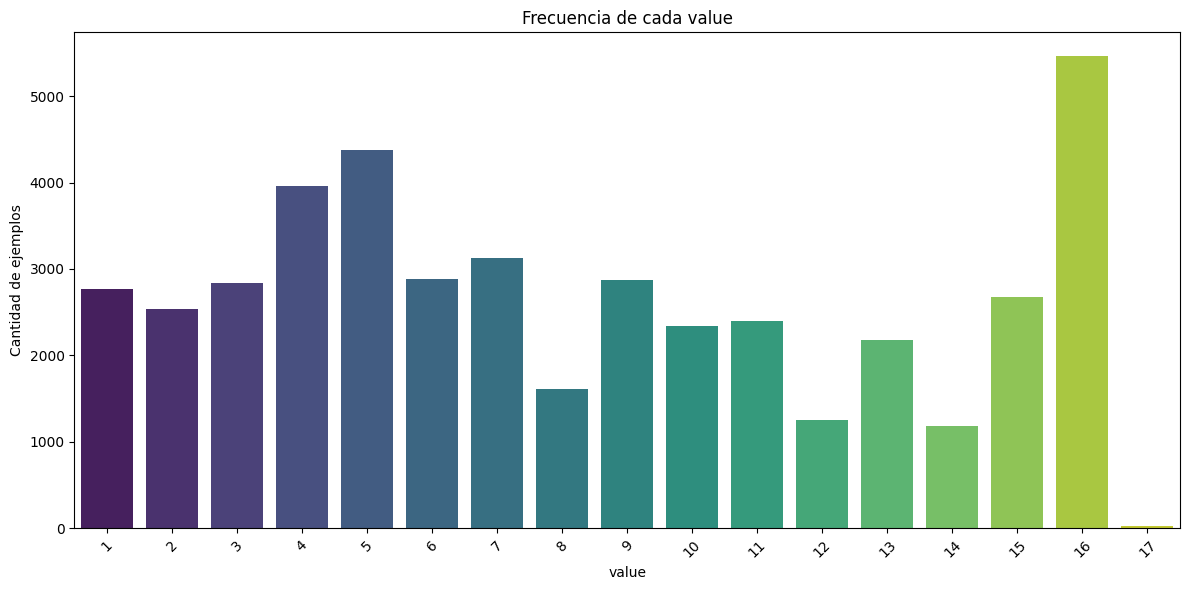

C:\Users\saraujo\AppData\Local\Temp\ipykernel_23524\3096793045.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=percentages.index, y=percentages.values, palette="magma")


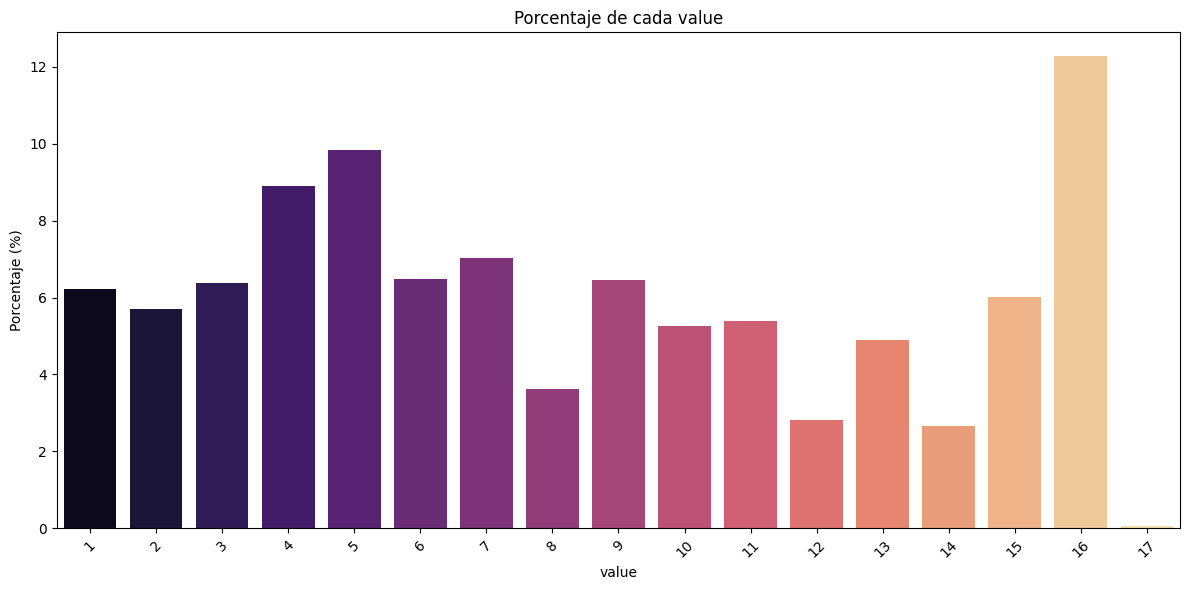

    value  Cantidad  Porcentaje
0       1      2768    6.224001
1       2      2533    5.695591
2       3      2836    6.376903
3       4      3958    8.899782
4       5      4376    9.839678
5       6      2882    6.480336
6       7      3121    7.017741
7       8      1606     3.61118
8       9      2868    6.448857
9      10      2342    5.266117
10     11      2400    5.396533
11     12      1250    2.810694
12     13      2180    4.901851
13     14      1184    2.662289
14     15      2674    6.012637
15     16      5464   12.286106
16     17        31    0.069705


In [274]:
graph_df(df_final)

In [275]:
# Eliminar los ODS con menor cantidad
values_target = df_final["value"].value_counts()[df_final["value"].value_counts() < 1000].index.to_list()
df_final_tmp = df_final[~df_final["value"].isin(values_target)]

df_final = df_final_tmp[(df_final_tmp["text"].str.len() > 120) & (df_final_tmp["text"].str.len() < 1025)]

C:\Users\saraujo\AppData\Local\Temp\ipykernel_23524\3096793045.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


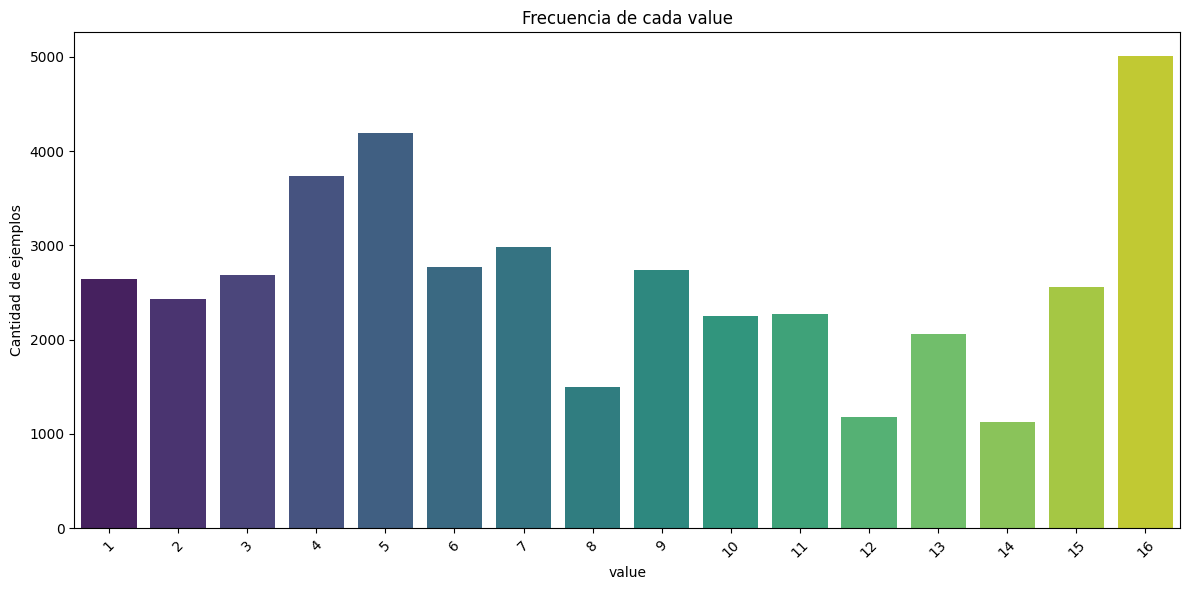

C:\Users\saraujo\AppData\Local\Temp\ipykernel_23524\3096793045.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=percentages.index, y=percentages.values, palette="magma")


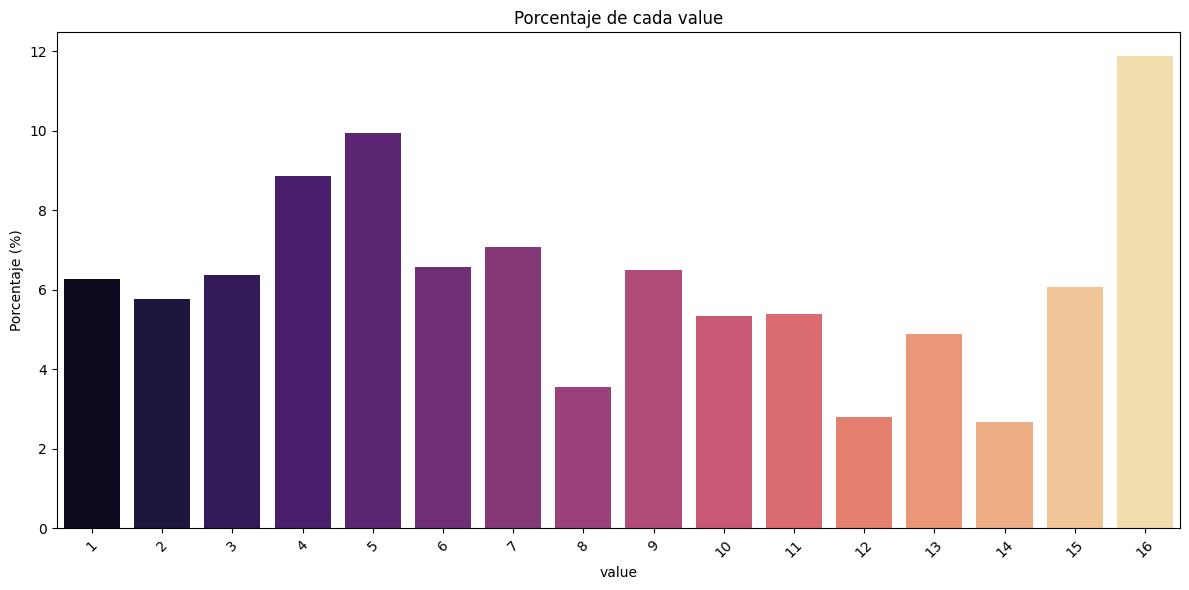

    value  Cantidad  Porcentaje
0       1      2645    6.276697
1       2      2428    5.761747
2       3      2684    6.369245
3       4      3739    8.872805
4       5      4187    9.935928
5       6      2772    6.578073
6       7      2987    7.088277
7       8      1500    3.559563
8       9      2738     6.49739
9      10      2253    5.346464
10     11      2270    5.386806
11     12      1175    2.788325
12     13      2060    4.888467
13     14      1131    2.683911
14     15      2562    6.079734
15     16      5009   11.886569


In [276]:
graph_df(df_final)

In [277]:
df_final.to_csv("./data/dataset.csv", index=False)